# Preparation

1) Package import 
2) Global variables set

In [1]:
import torch

from data import MakeDataLoader, MakeUnlearnLoader
from models import MNIST_Unet
from loops import TrainLoop, UnlearnLoop
from utils import distributionSampler


In [2]:
# DataLoader variables
DATASET = "mnist"
BATCH_SIZE = 64
SHUFFLE = True
UNLEARN_LABEL = 1

# Train loop variables
NUM_EPOCHS = 10
RESUME = False

# Unlearn variables
DIST_TYPE = "filtered"

# Device variable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Make dataloader

Sample size:  torch.Size([64, 1, 28, 28])
Labels size:  tensor([7, 7, 1, 8, 7, 8, 1, 1, 7, 8, 0, 9, 7, 1, 9, 6, 4, 1, 5, 5, 7, 2, 7, 3,
        8, 4, 4, 3, 4, 8, 8, 4, 5, 7, 1, 7, 9, 6, 9, 1, 4, 2, 4, 7, 6, 0, 3, 5,
        6, 4, 4, 4, 4, 7, 6, 6, 8, 9, 2, 5, 0, 5, 3, 8])


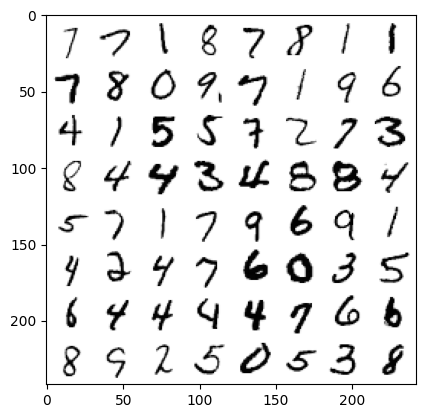

In [3]:
loader_maker = MakeDataLoader(
    ds_name=DATASET,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE
)

loader = loader_maker()


# Build model

In [4]:
model = MNIST_Unet()
print(f"Number of params: {sum(p.numel() for p in model.parameters())}")

Number of params: 1708201


# Unlearn

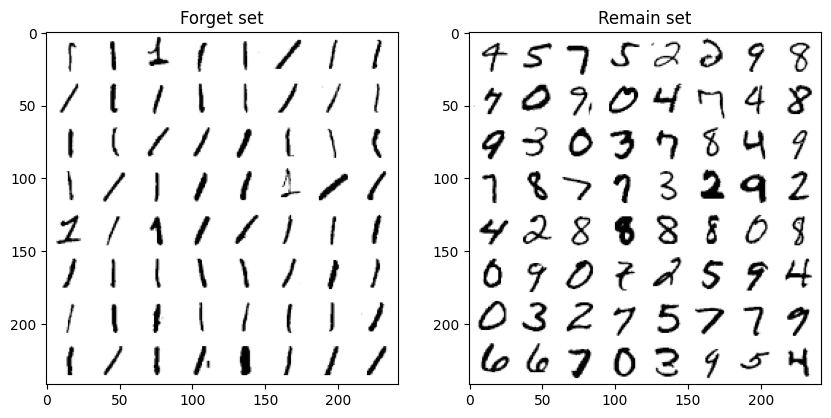

In [5]:
# Dataloader initialization

unlearn_maker = MakeUnlearnLoader(
    ds_name=DATASET,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    label=UNLEARN_LABEL
)

forget_loader, remain_loader = unlearn_maker()

In [6]:
sample = next(iter(remain_loader))[0]
dist_sampler = distributionSampler(distr_type=DIST_TYPE, sample=sample, device=DEVICE)

filtered


  0%|          | 0/500 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002436
Step 50. Avarage of the last 50 loss values: 0.051737
Step 100. Avarage of the last 50 loss values: 0.031656
Step 150. Avarage of the last 50 loss values: 0.029717
Step 200. Avarage of the last 50 loss values: 0.028239
Step 250. Avarage of the last 50 loss values: 0.029132
Step 300. Avarage of the last 50 loss values: 0.038437
Step 350. Avarage of the last 50 loss values: 0.039946
Step 400. Avarage of the last 50 loss values: 0.031806
Step 450. Avarage of the last 50 loss values: 0.030871


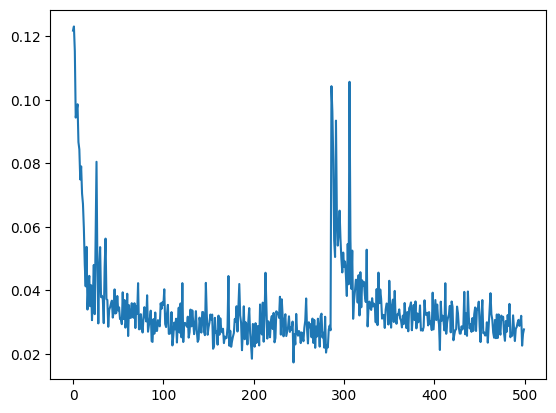

In [19]:
# Unlearning loop
loop = UnlearnLoop(
    data_loaders=(forget_loader, remain_loader),
    model=model,
    label_c=UNLEARN_LABEL,
    device=DEVICE,
    dist_sampler=dist_sampler,
    dist_type=DIST_TYPE,
    S=500
)

loop()

# Sample

In [20]:
from diffusers import DDPMScheduler
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torchvision

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')


In [21]:
model = MNIST_Unet()
model.load_state_dict(torch.load("models/checkpoints/mnist_1_filtered.pt"))

<All keys matched successfully>

0it [00:00, ?it/s]

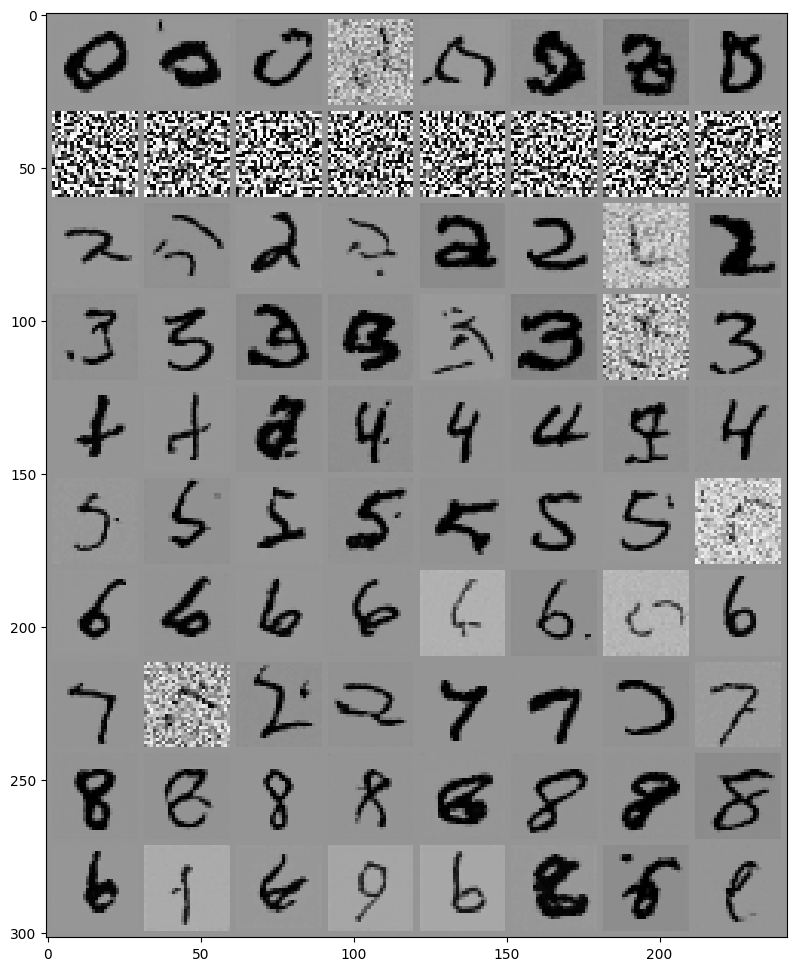

In [22]:

#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(DEVICE)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(DEVICE)
model.to(DEVICE)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')